# ch 2. word cloud

이전 챕터에서 2022년 한국 야구 데이터 셋을 토큰화 했습니다. 이번 챕터에서는 가장 기본적인 자연어 데이터 시각화 기법인 워드 클라우드에 대해서 알아보겠습니다. 워드 클라우드는 특정 단어와 함께 등장한 단어의 빈도 수를 집계해서, 어떤 단어가 연관되어 있는지를 시각적으로 표현하는 기법입니다.

In [1]:
!pip install wordcloud


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## 선수 이름 데이터 준비
우리가 만들어보고 싶은 건 특정 선수 이름이 주어지면, 그 선수와 함께 언급되는 단어들을 시각적으로 보여주는 것입니다. 이를 위해서 먼저 토큰화 한 뉴스 기사 데이터에서 특정 선수가 언급되면, 함께 언급된 단어들의 빈도수를 세어 딕셔너리 형태로 만들어보겠습니다. 

먼저 기사에 선수 이름이 포함되었는지 여부를 판단하기 위해 크롤러 시간에 짰던 코드를 재사용합니다.

In [3]:
import csv

players = []
with open("./data/baseball_players.csv") as fr:
    reader = csv.reader(fr)
    result = next(reader)
    for row in reader:
        team, pitchers, catchers, infielders, outfielders = row
        pitchers = pitchers.split("\n")
        catchers = catchers.split("\n")
        infielders = infielders.split("\n")
        outfielders = outfielders.split("\n")
        players.extend(pitchers + catchers + infielders + outfielders)

In [22]:
players_set = set(players)

## 기사 토큰화 환 데이터 셋 준비

토큰화한 데이터 셋을 순회하며 특정 기사에 선수 이름이 포함되어 있을 경우, 함께 언급된 일반 명사, 고유 명사의 빈도수를 세어서 딕셔너리에 추가합니다.

In [6]:
import pandas as pd
from tqdm import tqdm

In [12]:
df = pd.read_csv("./data/baseball_nouns.tsv", encoding="utf-8", sep="\t")

In [15]:
from tqdm import tqdm

tqdm.pandas()
df["nouns"] = df["nouns"].progress_apply(lambda x: eval(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102482/102482 [00:18<00:00, 5398.10it/s]


In [16]:
df

,nouns
0,"[출범, KBO, 모습, 정지, 택, KBO, 총재, KBO 리그, 응원, 주시, ..."
1,"[말씀, 프로, 무대, 데뷔, 신인, 선수, 선배, 사과, 이유, 사건, 10월 2..."
2,"[KBO, 총재, 신년사, 계획, 추진, 방향, 전달, 데일리안, 김태훈, 기자, ..."
3,"[겨울, KBO, 리그, 시장, 주목, 특징, 프랜차이즈, 스타, 무더기, 나성범,..."
4,"[임인, 새해, 야구팬, 응원, KBO 리그, 선수, 새해, 인사, 2021년, K..."
...,...
102477,"[코로나, 이후, 처음, 프로, 야구, 구단, 구단, 애리조나, 포함]"
102478,"[키움, 히어로즈, 이지영, 주전, 포수, 가치, 증명, 해, 지난, 시즌, 이지영..."
102479,"[사람, 승, 게, 바람, LG, 차명석, 단장, 1월, 말, LG, 유튜브, 채널..."
102480,"[이후, 관중, 달성, 2022년, 한국, 프로, 야구, KBO, 출범, 기념비, ..."


### 동시 출현 빈도 집계
특정 선수의 이름과 함께 등장한 명사를 defaultdict와 Counter를 이용해서 집계합니다.

In [40]:
from collections import Counter, defaultdict
from tqdm import tqdm

word_count_dict = defaultdict(Counter)

def count_words(nouns):
    # 기사에 등장한 선수 이름
    player_names = set(nouns).intersection(players_set)
    for player_name in player_names:
        c = Counter([x for x in nouns if x != player_name])
        word_count_dict[player_name] += c

In [41]:
df["nouns"].progress_apply(lambda x: count_words(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102482/102482 [02:57<00:00, 575.82it/s]


0         None
1         None
2         None
3         None
4         None
          ... 
102477    None
102478    None
102479    None
102480    None
102481    None
Name: nouns, Length: 102482, dtype: object

In [45]:
word_count_dict["이정후"].most_common(10)

[('키움', 44331),
 ('경기', 33734),
 ('안타', 32083),
 ('시즌', 31665),
 ('홈런', 22305),
 ('선수', 19590),
 ('타자', 18931),
 ('팀', 17608),
 ('SSG', 16220),
 ('리그', 16076)]

In [46]:
word_count_dict["김광현"].most_common(10)

[('SSG', 36038),
 ('경기', 28208),
 ('시즌', 25161),
 ('팀', 16658),
 ('승', 16535),
 ('선수', 15250),
 ('투수', 15146),
 ('리그', 14409),
 ('이닝', 14335),
 ('선발', 13918)]

## word cloud 시각화

함께 등장하는 단어를 세었으니 이제 워드 클라우드를 만들어보겠습니다. 폰트 적용 부분은 아래 가이드를 읽어보고, 본인의 환경에 맞게 코드를 수정하면 됩니다.

- [윈도우 폰트 적용 가이드](https://doitgrow.com/34#:~:text=%EC%9B%8C%EB%93%9C%ED%81%B4%EB%9D%BC%EC%9A%B0%EB%93%9C%EC%97%90%20%EC%82%AC%EC%9A%A9%ED%95%A0%20%ED%8F%B0%ED%8A%B8,%EA%B2%B0%EA%B3%BC%EB%A5%BC%20%ED%99%95%EC%9D%B8%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.)
- [맥 폰트 적용 가이드](https://business-analytics.tistory.com/3)

In [56]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def visualize_wordcloud(word_count, color):
    wordcloud = WordCloud(
        font_path="/Library/Fonts/NanumGothic.otf",
        width=1000, 
        height=400, 
        scale=2.0, 
        background_color='white', 
        colormap=color,
        max_font_size=150
    ).generate_from_frequencies(word_count)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)

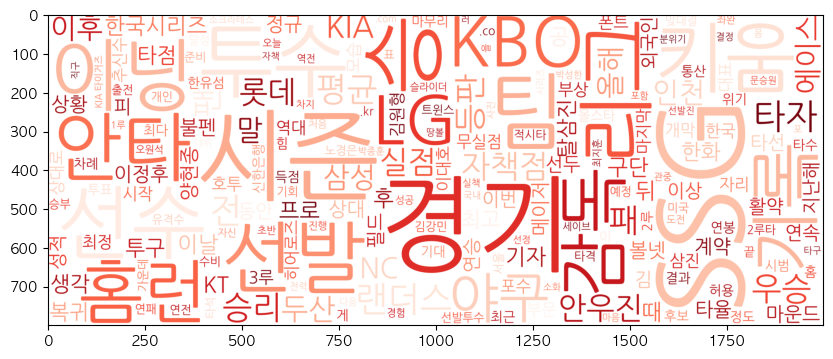

In [57]:
visualize_wordcloud(word_count_dict["김광현"], "Reds")

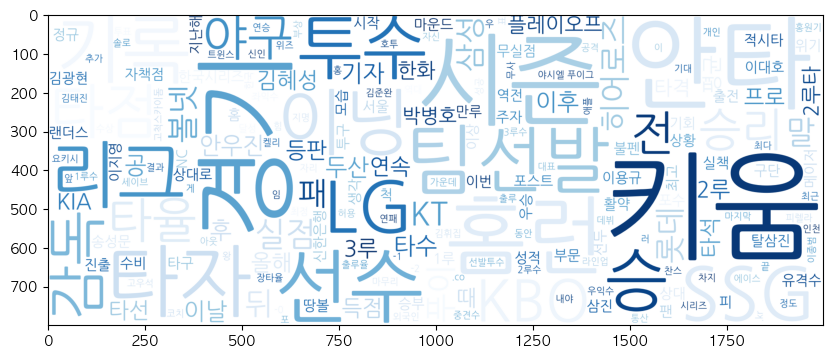

In [58]:
visualize_wordcloud(word_count_dict["이정후"], "Blues")

## 정리
이번 챕터에서는 자연어 데이터 시각화 하면 가장 먼저 떠오르는 워드 클라우드를 만들어 보았습니다. 사실 워드 클라우드는 직관적으로 의미를 전달하는 것이 어려워서 잘 사용되지 않습니다. 이어지는 챕터들에서 더 정교화 된 자연어처리 알고리즘들을 배워보겠습니다.